***Importamos las librerías necesarias :***

In [1]:
import os
import torch
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
from io import BytesIO
from pathlib import Path
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.models import alexnet, AlexNet_Weights
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from torchvision.models import densenet121, DenseNet121_Weights
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

***Guardamos las imágenes con sus respectivas clases en "complete_df" :***

In [2]:
image_dir = Path('./Imagenes/Trayectorias_dominio_tiempo_frecuencia/longitud_28/raw-img-v2')

file_paths = list(image_dir.rglob("*.jpg")) + \
             list(image_dir.rglob("*.jpeg")) + \
             list(image_dir.rglob("*.png"))

complete_df = pd.DataFrame()
complete_df['file_name'] = [str(p) for p in file_paths]
complete_df['class_name'] = complete_df['file_name'].map(lambda x: Path(x).parent.name)

### COMPROBACIÓN ###
print("Número total de imágenes:", len(complete_df))
class_counts = complete_df['class_name'].value_counts()
print(class_counts)


Número total de imágenes: 955
class_name
Cargo        648
Tanker       211
Container     96
Name: count, dtype: int64


***Dividimos "complete_df" en entrenamiento y test :***

In [3]:
complete_df = complete_df.sample(frac=1, random_state=42).reset_index(drop=True)

test_size = 0.2
train_df_list = []
test_df_list = []

classes = complete_df['class_name'].unique()

for class_name in classes:
    class_subset = complete_df[complete_df['class_name'] == class_name]
    
    test_count = int(len(class_subset) * test_size)
    
    test_df_list.append(class_subset.iloc[:test_count])
    train_df_list.append(class_subset.iloc[test_count:])

train_df = pd.concat(train_df_list).reset_index(drop=True)
test_df = pd.concat(test_df_list).reset_index(drop=True)

train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

#### COMPROBACIÓN ####
print(f"Nº de imágenes en train: {len(train_df)}")
print(train_df['class_name'].value_counts())
print()
print(f"Nº de imágenes en test: {len(test_df)}")
print(test_df['class_name'].value_counts())
print()
print("Ejm. conjunto train:")
print(train_df.head(10))
print()
print("Ejm. conjunto test:")
print(test_df.head(10))

Nº de imágenes en train: 765
class_name
Cargo        519
Tanker       169
Container     77
Name: count, dtype: int64

Nº de imágenes en test: 190
class_name
Cargo        129
Tanker        42
Container     19
Name: count, dtype: int64

Ejm. conjunto train:
                                           file_name class_name
0  Imagenes\Trayectorias_dominio_tiempo_frecuenci...      Cargo
1  Imagenes\Trayectorias_dominio_tiempo_frecuenci...      Cargo
2  Imagenes\Trayectorias_dominio_tiempo_frecuenci...     Tanker
3  Imagenes\Trayectorias_dominio_tiempo_frecuenci...      Cargo
4  Imagenes\Trayectorias_dominio_tiempo_frecuenci...      Cargo
5  Imagenes\Trayectorias_dominio_tiempo_frecuenci...  Container
6  Imagenes\Trayectorias_dominio_tiempo_frecuenci...     Tanker
7  Imagenes\Trayectorias_dominio_tiempo_frecuenci...      Cargo
8  Imagenes\Trayectorias_dominio_tiempo_frecuenci...      Cargo
9  Imagenes\Trayectorias_dominio_tiempo_frecuenci...      Cargo

Ejm. conjunto test:
                   

***Imágenes de entrenamiento y test antes del pre-procesado :***

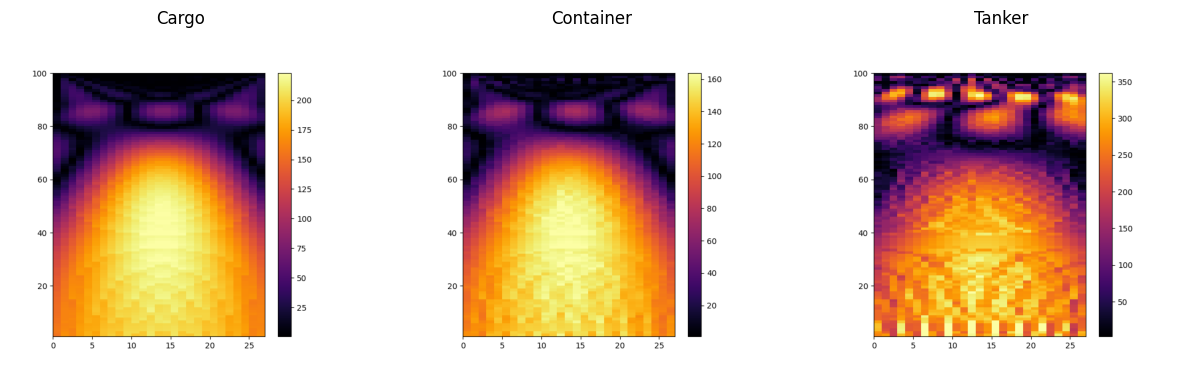

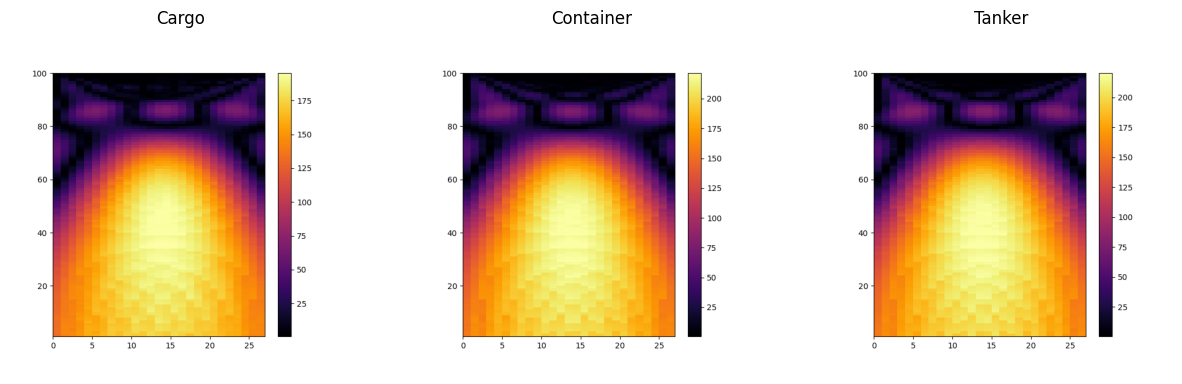

In [4]:
def mostrar_imagenes_antes_preprocesado(df):
    plt.figure(figsize=(15, 15))
    grouped = df.groupby('class_name')
    
    for i, (class_name, group) in enumerate(grouped):
        image_path = group['file_name'].iloc[0]
        image = Image.open(image_path).convert("RGB")
        
        plt.subplot(1, len(grouped), i + 1)
        plt.imshow(image)
        plt.title(class_name)
        plt.axis('off')
    
    plt.show()

mostrar_imagenes_antes_preprocesado(train_df)
mostrar_imagenes_antes_preprocesado(test_df)


***Pre-procesado de las imágenes :***

In [5]:
IMG_SIZE = (227, 227)
X_train = []
y_train = []
X_test = []
y_test = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device} disponible")

transform = transforms.Compose([transforms.Resize(IMG_SIZE),transforms.ToTensor()])

def preprocesado_imagen(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image)
    return image

for index, row in train_df.iterrows():
    image_tensor = preprocesado_imagen(row['file_name'])
    X_train.append(image_tensor)
    y_train.append(row['class_name'])

for index, row in test_df.iterrows():
    image_tensor = preprocesado_imagen(row['file_name'])
    X_test.append(image_tensor)
    y_test.append(row['class_name'])

X_train = torch.stack(X_train)
X_test = torch.stack(X_test)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

y_train = torch.tensor(y_train_encoded, dtype=torch.long)
y_test = torch.tensor(y_test_encoded, dtype=torch.long)

### COMPROBACIÓN ###
print("X_train:", X_train.shape, X_train.device)
print("y_train:", y_train.shape, y_train.device)
print("X_test:", X_test.shape, X_test.device)
print("y_test:", y_test.shape, y_test.device)


cuda disponible
X_train: torch.Size([765, 3, 227, 227]) cpu
y_train: torch.Size([765]) cpu
X_test: torch.Size([190, 3, 227, 227]) cpu
y_test: torch.Size([190]) cpu


# ***AlexNet :***

In [ ]:
def get_alexnet_model(num_classes, pretrained):
    if pretrained:
        modelo = alexnet(weights=AlexNet_Weights.DEFAULT)
    else:
        modelo = alexnet(weights=None)

    modelo.classifier[6] = nn.Linear(modelo.classifier[6].in_features, num_classes)

    if pretrained:
        for param in modelo.features.parameters():
            param.requires_grad = False
            
        for param in modelo.classifier[6].parameters():
            param.requires_grad = True

    return modelo

# ***Resultados AlexNet :***

    Representación 2:

1. ***Longitud 8 :***

- ***Sin Transfer Learning :***

  Epoch 25/25 ✅ | Train Acc: 20.08% - Train Loss: 1.6095 | Val Acc: 19.49% - Val Loss: 1.6097

- ***Con Transfer Learning :***

  Epoch 25/25 ✅ | Train Acc: 20.84% - Train Loss: 1.7337 | Val Acc: 20.27% - Val Loss: 1.7098

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

2. ***Longitud 18 :***

- ***Sin Transfer Learning :***

- ***Con Transfer Learning :***

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

3. ***Longitud 28 :***

- ***Sin Transfer Learning :***

- ***Con Transfer Learning :***

# # # # # # # # # # # # # # # # # # # # # # # #

    Representación 3:

1. ***Longitud 8 :***  

- ***Sin Transfer Learning :***

  Epoch 25/25 ✅ | Train Acc: 20.17% - Train Loss: 1.6095 | Val Acc: 19.49% - Val Loss: 1.6097

- ***Con Transfer Learning :***

  Epoch 25/25 ✅ | Train Acc: 20.79% - Train Loss: 1.7143 | Val Acc: 20.40% - Val Loss: 1.6673

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

2. ***Longitud 18 :***

- ***Sin Transfer Learning :***

- ***Con Transfer Learning :***

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

3. ***Longitud 28 :***

- ***Sin Transfer Learning :***

- ***Con Transfer Learning :***

---

# ***ResNet50 :***

In [6]:
def get_resnet50_model(num_classes, pretrained):
    if pretrained:
        modelo = resnet50(weights=ResNet50_Weights.DEFAULT)
    else:
        modelo = resnet50(weights=None)

    modelo.fc = nn.Linear(modelo.fc.in_features, num_classes)

    if pretrained:
        for param in modelo.parameters():
            param.requires_grad = False

        for param in modelo.fc.parameters():
            param.requires_grad = True

    return modelo

# ***Resultados ResNet50 :***

    Representación 2:

1. ***Longitud 8 :***

+ ***Sin Transfer Learning :***

  Epoch 25/25 ✅ | Train Acc: 22.38% - Train Loss: 1.6055 | Val Acc: 20.44% - Val Loss: 1.6144

+ ***Con Transfer Learning :***

  Epoch 25/25 ✅ | Train Acc: 34.95% - Train Loss: 1.5001 | Val Acc: 21.30% - Val Loss: 1.6551

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

2. ***Longitud 18 :***

+ ***Sin Transfer Learning :***

+ ***Con Transfer Learning :***

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

3. ***Longitud 28 :***

+ ***Sin Transfer Learning :***

+ ***Con Transfer Learning :***

# # # # # # # # # # # # # # # # # # # # # # # #

    Representación 3:

1. ***Longitud 8 :***

+ ***Sin Transfer Learning :***

  Epoch 25/25 ✅ | Train Acc: 20.30% - Train Loss: 1.6151 | Val Acc: 20.70% - Val Loss: 1.6261

+ ***Con Transfer Learning :***

  Epoch 25/25 ✅ | Train Acc: 39.60% - Train Loss: 1.4347 | Val Acc: 21.39% - Val Loss: 1.6936

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

2. ***Longitud 18 :***

+ ***Sin Transfer Learning :***

+ ***Con Transfer Learning :***

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

3. ***Longitud 28 :***

+ ***Sin Transfer Learning :***

+ ***Con Transfer Learning :***

---

# ***DenseNet121 :***

In [7]:
def get_densenet121_model(num_classes, pretrained):
    if pretrained:
        modelo = densenet121(weights=DenseNet121_Weights.DEFAULT)
    else:
        modelo = densenet121(weights=None)

    modelo.classifier = nn.Linear(modelo.classifier.in_features, num_classes)

    if pretrained:
        for param in modelo.parameters():
            param.requires_grad = False

        for param in modelo.classifier.parameters():
            param.requires_grad = True

    return modelo

# ***Resultados DenseNet121 :***

    Representación 2 :

1. ***Longitud 8 :***

- ***Sin Transfer Learning :***

  Epoch 25/25 ✅ | Train Acc: 21.43% - Train Loss: 1.6078 | Val Acc: 20.83% - Val Loss: 1.6085

- ***Con Transfer Learning :***

  Epoch 25/25 ✅ | Train Acc: 29.16% - Train Loss: 1.5748 | Val Acc: 19.71% - Val Loss: 1.6962

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

2. ***Longitud 18 :***

- ***Sin Transfer Learning :***

- ***Con Transfer Learning :***

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

3. ***Longitud 28 :***

- ***Sin Transfer Learning :***

- ***Con Transfer Learning :***

# # # # # # # # # # # # # # # # # # # # # # # #

    Representación 3 :

1. ***Longitud 8 :***

- ***Sin Transfer Learning :***

  Epoch 25/25 ✅ | Train Acc: 20.05% - Train Loss: 1.6096 | Val Acc: 19.49% - Val Loss: 1.6099

- ***Con Transfer Learning :***

  Epoch 25/25 ✅ | Train Acc: 27.92% - Train Loss: 1.5820 | Val Acc: 19.71% - Val Loss: 1.6737

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

2. ***Longitud 18 :***

- ***Sin Transfer Learning :***

- ***Con Transfer Learning :***

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

3. ***Longitud 28 :***

- ***Sin Transfer Learning :***

- ***Con Transfer Learning :***

---

# ***ConvNeXt Tiny :***

In [8]:
def get_convnext_tiny_model(num_classes, pretrained):
    if pretrained:
        modelo = convnext_tiny(weights=ConvNeXt_Tiny_Weights.DEFAULT)
    else:
        modelo = convnext_tiny(weights=None)

    modelo.classifier[2] = nn.Linear(modelo.classifier[2].in_features, num_classes)

    if pretrained:
        for param in modelo.parameters():
            param.requires_grad = False

        for param in modelo.classifier[2].parameters():
            param.requires_grad = True

    return modelo

# ***Resultados ConvNeXt Tiny :***

    Representación 2 :

1. ***Longitud 8 :***

+ ***Sin Transfer Learning :***

  Epoch 25/25 ✅ | Train Acc: 20.11% - Train Loss: 1.6105 | Val Acc: 20.70% - Val Loss: 1.6094

+ ***Con Transfer Learning :***

  Epoch 25/25 ✅ | Train Acc: 24.34% - Train Loss: 1.6074 | Val Acc: 21.86% - Val Loss: 1.6451

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

2. ***Longitud 18 :***

+ ***Sin Transfer Learning :***

+ ***Con Transfer Learning :***

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

3. ***Longitud 28 :***

+ ***Sin Transfer Learning :***

+ ***Con Transfer Learning :***

# # # # # # # # # # # # # # # # # # # # # # # #

    Representación 3 :

1. ***Longitud 8 :***  

+ ***Sin Transfer Learning :***

  Epoch 25/25 ✅ | Train Acc: 20.44% - Train Loss: 1.6106 | Val Acc: 18.93% - Val Loss: 1.6116

+ ***Con Transfer Learning :***

  Epoch 25/25 ✅ | Train Acc: 19.91% - Train Loss: 1.6272 | Val Acc: 19.02% - Val Loss: 1.6181
  
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

2. ***Longitud 18 :***

+ ***Sin Transfer Learning :***

+ ***Con Transfer Learning :***

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

3. ***Longitud 28 :***

+ ***Sin Transfer Learning :***

+ ***Con Transfer Learning :***

---

***Entrenamiento del modelo :***

In [9]:
k_folds = 2
batch_size = 32
num_epochs = 20
num_classes = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = TensorDataset(X_train, y_train)
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

fold_train_acc = []
fold_train_loss = []
fold_val_acc = []
fold_val_loss = []

best_val_acc = 0

for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
    print(f"\n📂 Fold {fold+1}/{k_folds}")

    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)

    #nombre_modelo = "AlexNet"
    #modelo = get_alexnet_model(num_classes=num_classes, pretrained=False).to(device)
    
    nombre_modelo = "ResNet50"
    modelo = get_resnet50_model(num_classes=num_classes, pretrained=True).to(device)
    
    #nombre_modelo = "DenseNet121"
    #modelo = get_densenet121_model(num_classes=num_classes, pretrained=True).to(device)
    
    #nombre_modelo = "ConvNeXt_Tiny"
    #modelo = get_convnext_tiny_model(num_classes=num_classes, pretrained=True).to(device)


    #Longitud 8
    #weights = [1.0, 3.2, 6.4]

    #Longitud 18
    #weights = [1.0, 3.2, 6.6]

    #Longitud 28
    weights = [1.0, 3.1, 6.7]

    criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights).to(device))
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, modelo.parameters()), lr=0.001)

    for epoch in range(num_epochs):
        modelo.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for images, labels in tqdm(train_loader, desc=f"Fold {fold+1} | Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()
            output = modelo(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(output, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        modelo.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                output = modelo(images)
                loss = criterion(output, labels)
                _, predicted = torch.max(output, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val

        print(f"Fold {fold+1} - Epoch {epoch+1} ✅ | Train Acc: {train_acc:.2f}% - Train Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.2f}% - Val Loss: {avg_val_loss:.4f}")

    fold_train_acc.append(train_acc)
    fold_val_acc.append(val_acc)
    fold_train_loss.append(avg_train_loss)
    fold_val_loss.append(avg_val_loss)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(modelo.state_dict(), f"{nombre_modelo}_fold_{fold+1}_v2.pth")

print("\nRESULTADOS:")
print(f"-> Mean Train Accuracy: {np.mean(fold_train_acc):.4f}%")
print(f"-> Mean Train Loss: {np.mean(fold_train_loss):.4f}")
print(f"-> Mean Validation Accuracy: {np.mean(fold_val_acc):.4f}%")
print(f"-> Mean Validation Loss: {np.mean(fold_val_loss):.4f}")


📂 Fold 1/2


Fold 1 | Epoch 1/20: 100%|██████████| 12/12 [00:19<00:00,  1.62s/it]


Fold 1 - Epoch 1 ✅ | Train Acc: 23.56% - Train Loss: 0.9790 | Val Acc: 23.24% - Val Loss: 0.9374


Fold 1 | Epoch 2/20: 100%|██████████| 12/12 [00:07<00:00,  1.62it/s]


Fold 1 - Epoch 2 ✅ | Train Acc: 27.75% - Train Loss: 0.9169 | Val Acc: 27.42% - Val Loss: 0.9311


Fold 1 | Epoch 3/20: 100%|██████████| 12/12 [00:07<00:00,  1.53it/s]


Fold 1 - Epoch 3 ✅ | Train Acc: 39.53% - Train Loss: 0.8751 | Val Acc: 34.46% - Val Loss: 0.9130


Fold 1 | Epoch 4/20: 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]


Fold 1 - Epoch 4 ✅ | Train Acc: 32.98% - Train Loss: 0.8613 | Val Acc: 37.08% - Val Loss: 0.8796


Fold 1 | Epoch 5/20: 100%|██████████| 12/12 [00:08<00:00,  1.50it/s]


Fold 1 - Epoch 5 ✅ | Train Acc: 49.21% - Train Loss: 0.8418 | Val Acc: 37.60% - Val Loss: 0.8759


Fold 1 | Epoch 6/20: 100%|██████████| 12/12 [00:08<00:00,  1.50it/s]


Fold 1 - Epoch 6 ✅ | Train Acc: 38.48% - Train Loss: 0.8155 | Val Acc: 41.51% - Val Loss: 0.8836


Fold 1 | Epoch 7/20: 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]


Fold 1 - Epoch 7 ✅ | Train Acc: 52.88% - Train Loss: 0.8075 | Val Acc: 34.99% - Val Loss: 0.8686


Fold 1 | Epoch 8/20: 100%|██████████| 12/12 [00:08<00:00,  1.48it/s]


Fold 1 - Epoch 8 ✅ | Train Acc: 37.70% - Train Loss: 0.8108 | Val Acc: 47.00% - Val Loss: 0.9148


Fold 1 | Epoch 9/20: 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]


Fold 1 - Epoch 9 ✅ | Train Acc: 54.97% - Train Loss: 0.7983 | Val Acc: 30.55% - Val Loss: 0.8669


Fold 1 | Epoch 10/20: 100%|██████████| 12/12 [00:08<00:00,  1.48it/s]


Fold 1 - Epoch 10 ✅ | Train Acc: 48.95% - Train Loss: 0.7757 | Val Acc: 40.73% - Val Loss: 0.8741


Fold 1 | Epoch 11/20: 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]


Fold 1 - Epoch 11 ✅ | Train Acc: 51.57% - Train Loss: 0.7594 | Val Acc: 40.99% - Val Loss: 0.8800


Fold 1 | Epoch 12/20: 100%|██████████| 12/12 [00:08<00:00,  1.50it/s]


Fold 1 - Epoch 12 ✅ | Train Acc: 56.28% - Train Loss: 0.7533 | Val Acc: 39.43% - Val Loss: 0.8856


Fold 1 | Epoch 13/20: 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]


Fold 1 - Epoch 13 ✅ | Train Acc: 52.88% - Train Loss: 0.7381 | Val Acc: 45.69% - Val Loss: 0.8945


Fold 1 | Epoch 14/20: 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]


Fold 1 - Epoch 14 ✅ | Train Acc: 54.45% - Train Loss: 0.7303 | Val Acc: 40.99% - Val Loss: 0.8807


Fold 1 | Epoch 15/20: 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]


Fold 1 - Epoch 15 ✅ | Train Acc: 60.99% - Train Loss: 0.7452 | Val Acc: 36.81% - Val Loss: 0.8708


Fold 1 | Epoch 16/20: 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]


Fold 1 - Epoch 16 ✅ | Train Acc: 47.12% - Train Loss: 0.7400 | Val Acc: 49.35% - Val Loss: 0.9358


Fold 1 | Epoch 17/20: 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]


Fold 1 - Epoch 17 ✅ | Train Acc: 68.85% - Train Loss: 0.7455 | Val Acc: 38.90% - Val Loss: 0.8884


Fold 1 | Epoch 18/20: 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


Fold 1 - Epoch 18 ✅ | Train Acc: 47.91% - Train Loss: 0.7376 | Val Acc: 48.83% - Val Loss: 0.9386


Fold 1 | Epoch 19/20: 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]


Fold 1 - Epoch 19 ✅ | Train Acc: 68.59% - Train Loss: 0.7071 | Val Acc: 39.69% - Val Loss: 0.8880


Fold 1 | Epoch 20/20: 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


Fold 1 - Epoch 20 ✅ | Train Acc: 52.36% - Train Loss: 0.6826 | Val Acc: 47.52% - Val Loss: 0.9196

📂 Fold 2/2


Fold 2 | Epoch 1/20: 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]


Fold 2 - Epoch 1 ✅ | Train Acc: 23.24% - Train Loss: 0.9163 | Val Acc: 20.94% - Val Loss: 0.9622


Fold 2 | Epoch 2/20: 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]


Fold 2 - Epoch 2 ✅ | Train Acc: 23.24% - Train Loss: 0.8720 | Val Acc: 21.47% - Val Loss: 0.9432


Fold 2 | Epoch 3/20: 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]


Fold 2 - Epoch 3 ✅ | Train Acc: 28.98% - Train Loss: 0.8728 | Val Acc: 21.73% - Val Loss: 0.9509


Fold 2 | Epoch 4/20: 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]


Fold 2 - Epoch 4 ✅ | Train Acc: 29.50% - Train Loss: 0.7923 | Val Acc: 24.87% - Val Loss: 0.9394


Fold 2 | Epoch 5/20: 100%|██████████| 12/12 [00:09<00:00,  1.32it/s]


Fold 2 - Epoch 5 ✅ | Train Acc: 26.63% - Train Loss: 0.7856 | Val Acc: 24.08% - Val Loss: 0.9362


Fold 2 | Epoch 6/20: 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]


Fold 2 - Epoch 6 ✅ | Train Acc: 32.64% - Train Loss: 0.7674 | Val Acc: 20.16% - Val Loss: 0.9530


Fold 2 | Epoch 7/20: 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


Fold 2 - Epoch 7 ✅ | Train Acc: 29.77% - Train Loss: 0.7582 | Val Acc: 28.80% - Val Loss: 0.9515


Fold 2 | Epoch 8/20: 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


Fold 2 - Epoch 8 ✅ | Train Acc: 34.20% - Train Loss: 0.7501 | Val Acc: 25.92% - Val Loss: 0.9486


Fold 2 | Epoch 9/20: 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


Fold 2 - Epoch 9 ✅ | Train Acc: 41.78% - Train Loss: 0.7243 | Val Acc: 24.61% - Val Loss: 0.9505


Fold 2 | Epoch 10/20: 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


Fold 2 - Epoch 10 ✅ | Train Acc: 35.51% - Train Loss: 0.7233 | Val Acc: 36.39% - Val Loss: 0.9651


Fold 2 | Epoch 11/20: 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]


Fold 2 - Epoch 11 ✅ | Train Acc: 48.83% - Train Loss: 0.7098 | Val Acc: 23.56% - Val Loss: 0.9666


Fold 2 | Epoch 12/20: 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]


Fold 2 - Epoch 12 ✅ | Train Acc: 31.85% - Train Loss: 0.7141 | Val Acc: 34.82% - Val Loss: 0.9692


Fold 2 | Epoch 13/20: 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]


Fold 2 - Epoch 13 ✅ | Train Acc: 62.92% - Train Loss: 0.7254 | Val Acc: 24.08% - Val Loss: 0.9660


Fold 2 | Epoch 14/20: 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


Fold 2 - Epoch 14 ✅ | Train Acc: 29.50% - Train Loss: 0.7553 | Val Acc: 43.19% - Val Loss: 0.9778


Fold 2 | Epoch 15/20: 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]


Fold 2 - Epoch 15 ✅ | Train Acc: 56.14% - Train Loss: 0.6886 | Val Acc: 26.18% - Val Loss: 0.9700


Fold 2 | Epoch 16/20: 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


Fold 2 - Epoch 16 ✅ | Train Acc: 40.47% - Train Loss: 0.6820 | Val Acc: 37.17% - Val Loss: 0.9679


Fold 2 | Epoch 17/20: 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]


Fold 2 - Epoch 17 ✅ | Train Acc: 45.17% - Train Loss: 0.6614 | Val Acc: 31.15% - Val Loss: 0.9618


Fold 2 | Epoch 18/20: 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]


Fold 2 - Epoch 18 ✅ | Train Acc: 43.60% - Train Loss: 0.6424 | Val Acc: 32.20% - Val Loss: 0.9692


Fold 2 | Epoch 19/20: 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


Fold 2 - Epoch 19 ✅ | Train Acc: 46.48% - Train Loss: 0.6455 | Val Acc: 37.96% - Val Loss: 0.9677


Fold 2 | Epoch 20/20: 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


Fold 2 - Epoch 20 ✅ | Train Acc: 53.52% - Train Loss: 0.6268 | Val Acc: 29.32% - Val Loss: 0.9696

RESULTADOS:
-> Mean Train Accuracy: 52.9404%
-> Mean Train Loss: 0.6547
-> Mean Validation Accuracy: 38.4195%
-> Mean Validation Loss: 0.9446


***Graficar los resultados del entrenamiento :***

ValueError: x and y must have same first dimension, but have shapes (20,) and (1,)

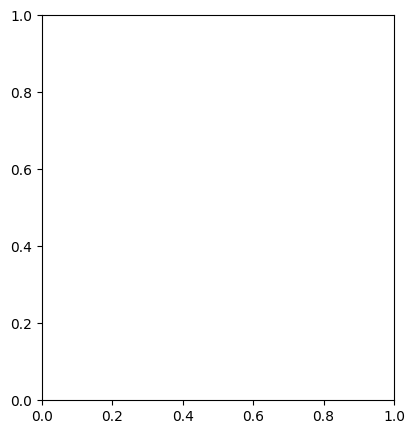

In [14]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_acc, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), avg_train_loss, label="Train Loss")
plt.plot(range(1, num_epochs + 1), avg_val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

output_dir = './Resultados_entrenamiento'
nombre_modelo = 'ConvNext_Tiny'
os.makedirs(output_dir, exist_ok=True)
plt.savefig(f'{output_dir}/{nombre_modelo}.png')
plt.show()

***Cargar el modelo :***

In [10]:
modelo.load_state_dict(torch.load("ResNet50_fold_1_v2.pth"))
modelo.to(device)
modelo.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

***Evaluar el modelo :***

In [11]:
all_preds = []
all_labels = []

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelo(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

***Matriz de confusión :***

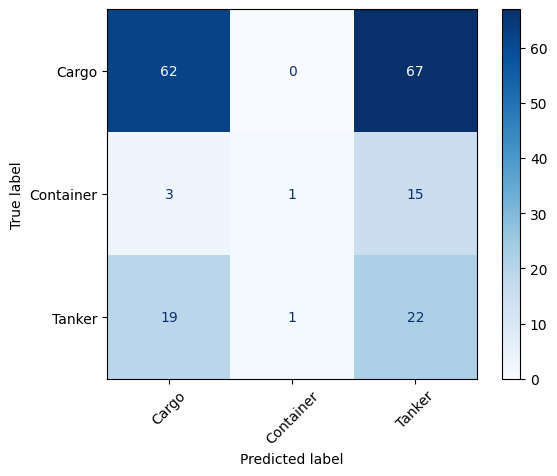

In [12]:
#class_names = ['Cargo','Container','Cruise','Fishing','Tanker']
class_names = ['Cargo', 'Container','Tanker']
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.show()

***Análisis de los resultados obtenidos :***

In [13]:
print(classification_report(all_labels, all_preds, target_names=class_names))

              precision    recall  f1-score   support

       Cargo       0.74      0.48      0.58       129
   Container       0.50      0.05      0.10        19
      Tanker       0.21      0.52      0.30        42

    accuracy                           0.45       190
   macro avg       0.48      0.35      0.33       190
weighted avg       0.60      0.45      0.47       190

